In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='linear', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def test_step(self, data):
        x = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructed_x = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 88, 8)        32          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 44, 8)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 44, 16)       400         ['max_pooling1d[0][0]']          
                                                                                            

In [2]:
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(
                                    features, labels, test_size=0.2, random_state=42)

x_train_seq = x_train.values[:, 0]
x_test_seq = x_test.values[:, 0]

x_train_features = x_train.values[:, 1:]
x_test_features = x_test.values[:, 1:]

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [3]:
learn_rate = [0.005, 0.01]
batch_size = [32, 64]
#learn_rate = [0.005, 0.01, 0.05, 0.1]
#batch_size = [32, 64, 128, 256]

param_grid = dict(learn_rate=learn_rate, batch_size=batch_size)

best_score = None
best_params = {}

for lr in learn_rate:
    for bs in batch_size:
        
        vae = VAE(encoder, decoder)
        vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

        vae.fit(x_train, batch_size=bs, epochs=3)

        score = vae.evaluate(x_test)

        if best_score is None or score < best_score:
            best_score = score
            best_params = {'learn_rate': lr, 'batch_size': bs}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

lr = best_params['learn_rate']
bs = best_params['batch_size']

Epoch 1/3
262/262 [==============================] - 3s 5ms/step - loss: 3.3015 - reconstruction_loss: 1.5379 - kl_loss: 0.0566
Epoch 2/3
262/262 [==============================] - 1s 5ms/step - loss: 0.9800 - reconstruction_loss: 0.9800 - kl_loss: 1.7943e-04
Epoch 3/3
66/66 [==============================] - 0s 2ms/step - total_loss: 0.9225 - reconstruction_loss: 0.9224 - kl_loss: 8.6762e-05
Epoch 1/3
131/131 [==============================] - 3s 8ms/step - loss: 1.1149 - reconstruction_loss: 1.0056 - kl_loss: 9.8585e-04
Epoch 2/3
131/131 [==============================] - 1s 8ms/step - loss: 0.9714 - reconstruction_loss: 0.9613 - kl_loss: 2.3880e-06
Epoch 3/3
66/66 [==============================] - 1s 2ms/step - total_loss: 0.9088 - reconstruction_loss: 0.9088 - kl_loss: 4.9671e-07
Epoch 1/3
262/262 [==============================] - 3s 5ms/step - loss: 1.0630 - reconstruction_loss: 0.9945 - kl_loss: 1.4241e-04
Epoch 2/3
262/262 [==============================] - 1s 5ms/step - loss:

In [4]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)

vae.fit(x_train, batch_size=bs, epochs=50, validation_data=(x_test,),
        callbacks=[reduce_lr, early_stop])

Epoch 1/50
131/131 [==============================] - 3s 12ms/step - loss: 0.9825 - reconstruction_loss: 0.9617 - kl_loss: 8.8042e-06 - val_total_loss: 0.8695 - val_reconstruction_loss: 0.8695 - val_kl_loss: 2.6822e-06 - lr: 0.0050
Epoch 2/50
131/131 [==============================] - 1s 9ms/step - loss: 0.9567 - reconstruction_loss: 0.9567 - kl_loss: 1.2121e-06 - val_total_loss: 0.8715 - val_reconstruction_loss: 0.8715 - val_kl_loss: 1.4603e-06 - lr: 0.0050
Epoch 3/50
131/131 [==============================] - 1s 9ms/step - loss: 0.9500 - reconstruction_loss: 0.9568 - kl_loss: 6.2244e-07 - val_total_loss: 0.8756 - val_reconstruction_loss: 0.8756 - val_kl_loss: 4.1723e-07 - lr: 0.0050
Epoch 4/50
131/131 [==============================] - 1s 9ms/step - loss: 0.9596 - reconstruction_loss: 0.9569 - kl_loss: 1.7975e-06 - val_total_loss: 0.8704 - val_reconstruction_loss: 0.8704 - val_kl_loss: 1.4901e-07 - lr: 0.0050
Epoch 5/50
127/131 [============================>.] - ETA: 0s - loss: 0.961

In [5]:
#print(x_test.shape)
#print(y_test.shape)

validation_loss = vae.evaluate(x_test,)
print("Validation Loss:", validation_loss)


66/66 [==============================] - 0s 2ms/step - total_loss: 0.9156 - reconstruction_loss: 0.9156 - kl_loss: 5.9605e-08
Validation Loss: [0.91556715965271, 0.9155671000480652, 5.960464477539063e-08]


In [6]:
import matplotlib.pyplot as plt

_, _, z_input = encoder.predict(x_train)
reconstructed_z_input = vae.decoder.predict(z_input)
_, _, reconstructed_z_encoded = vae.encoder.predict(reconstructed_z_input)

_, _, z_test_input = encoder.predict(x_test)
reconstructed_z_test_input = vae.decoder.predict(z_test_input)
_, _, reconstructed_z_test_encoded = vae.encoder.predict(reconstructed_z_test_input)

66/66 [==============================] - 0s 923us/step


In [7]:
#print(x_test[0])
#print(reconstructed_z_test_input[0])
print(z_test_input[2])
print(reconstructed_z_test_encoded[2])

[ 1.5812749  -0.49041596]
[ 0.02449536 -0.6896024 ]


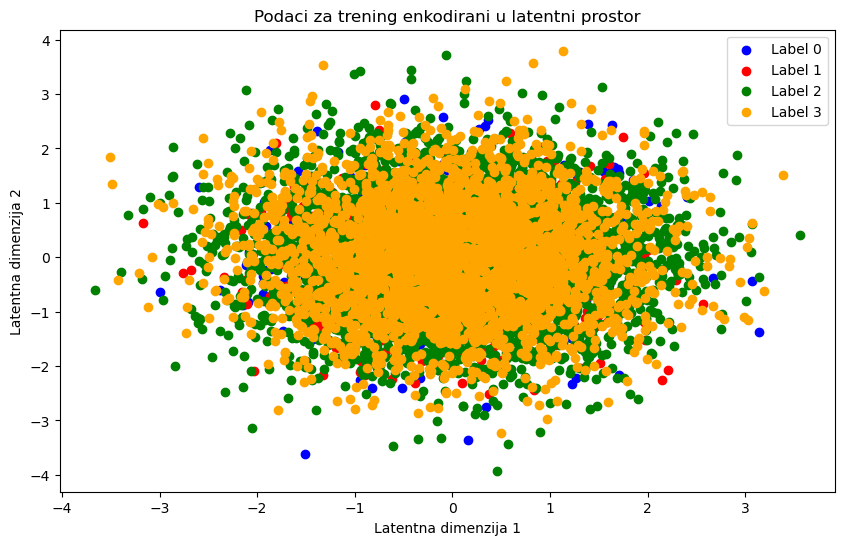

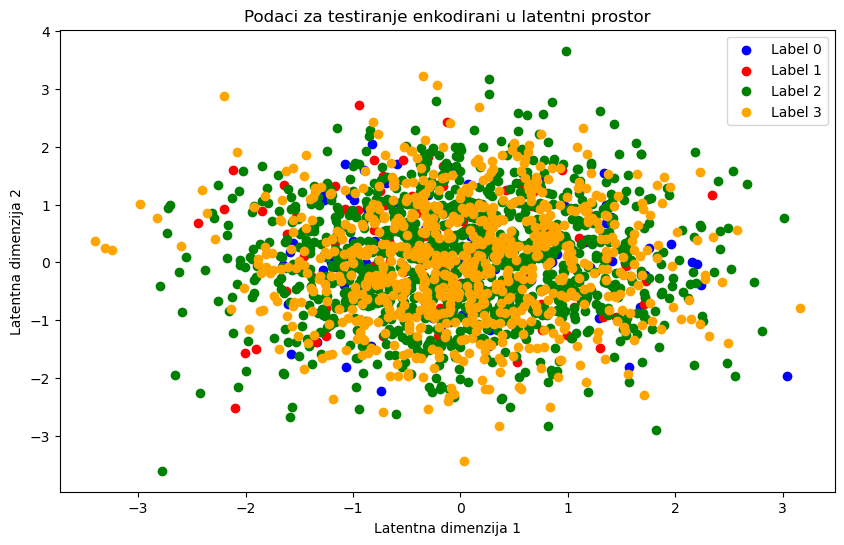

In [8]:
def plot_input_data(x_data, y_data):
    z_input = x_data
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za trening enkodirani u latentni prostor")
plot_input_data(z_input, y_train)

plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

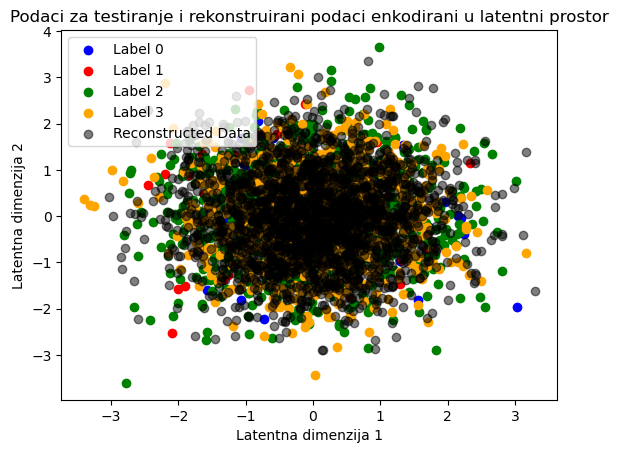

In [15]:
def plot_input_and_reconstructed_data(x_input_data, x_reconstructed, y_input_data):
    z_input = x_input_data
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_input_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_input_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.scatter(recon_data_lsp[:, 0], recon_data_lsp[:, 1], c='black', alpha=0.5, label='Reconstructed Data')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title("Podaci za testiranje i rekonstruirani podaci enkodirani u latentni prostor")
    plt.legend()
    plt.show()

plot_input_and_reconstructed_data(z_test_input, reconstructed_z_test_encoded, y_test)


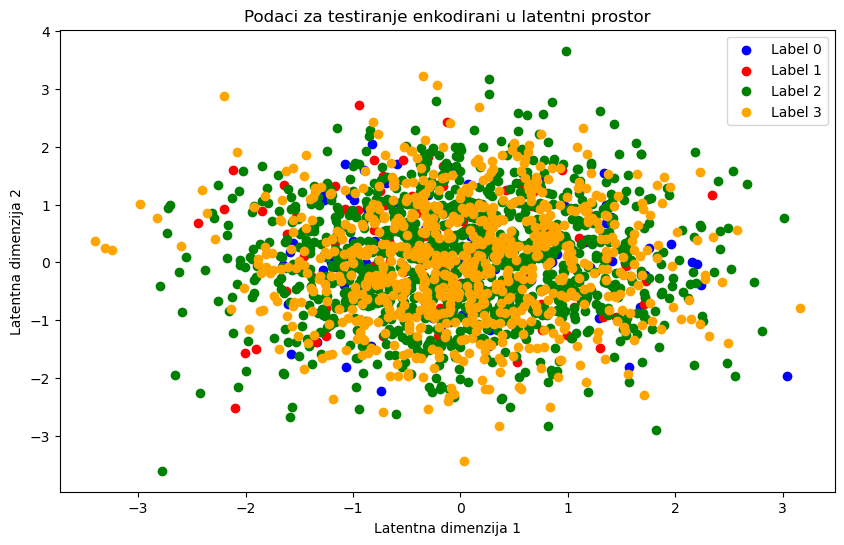

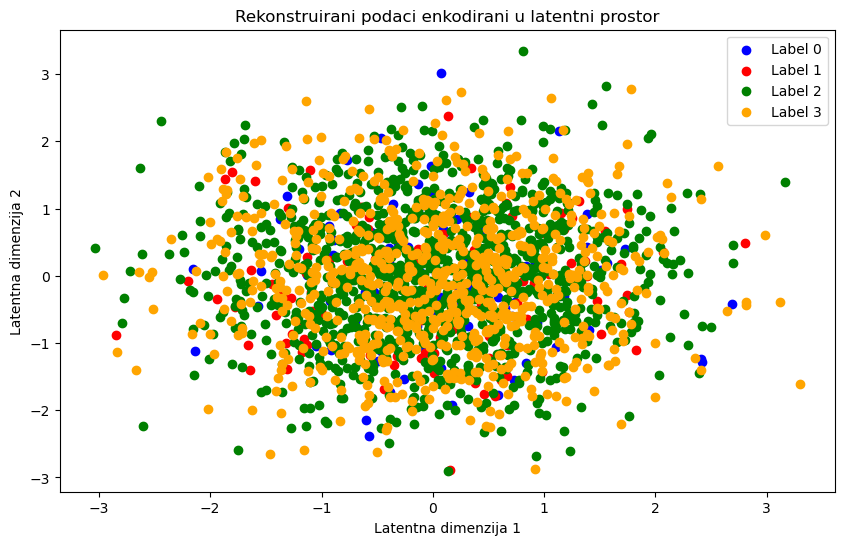

In [10]:
def plot_reconstructed_data(x_reconstructed, y_data):
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(recon_data_lsp[indices, 0], recon_data_lsp[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirani podaci enkodirani u latentni prostor")
plot_reconstructed_data(reconstructed_z_test_encoded, y_test)

In [16]:
from Bio import pairwise2
from Bio.Seq import Seq

def calculate_sequence_similarity(seq1, seq2):
    # Convert the sequences to Seq objects
    seq1 = Seq(seq1)
    seq2 = Seq(seq2)

    # Perform global sequence alignment
    alignments = pairwise2.align.globalxx(seq1, seq2)

    # Get the alignment with the best score (the first one in the list)
    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned, score, begin, end = best_alignment

    # Calculate similarity as a percentage
    similarity = (score / max(len(seq1), len(seq2)))

    return similarity

similarities_train = []
similarities_test = []

for i in range(50):
    row_similarities_train = []
    row_similarities_test = []
    for j in range(50,101):
        sim_train = calculate_sequence_similarity(x_train_seq[i], x_train_seq[j])
        sim_test = calculate_sequence_similarity(x_test_seq[i], x_test_seq[j])
        row_similarities_train.append(sim_train)
        row_similarities_test.append(sim_test)
        
    similarities_train.append(row_similarities_train)
    similarities_test.append(row_similarities_test)
    
similarities_train = np.array(similarities_train)
similarities_test = np.array(similarities_test)

print(similarities_train)
print(similarities_test)

[[0.25581395 0.13953488 0.39534884 ... 0.39534884 0.18604651 0.34883721]
 [0.1025641  0.         0.12820513 ... 0.13157895 0.125      0.05263158]
 [0.20512821 0.28       0.23076923 ... 0.18421053 0.32       0.23684211]
 ...
 [0.33333333 0.21621622 0.35897436 ... 0.34210526 0.32432432 0.34210526]
 [0.33333333 0.17777778 0.26666667 ... 0.33333333 0.22222222 0.33333333]
 [0.07692308 0.25       0.15384615 ... 0.18421053 0.16666667 0.23684211]]
[[0.27272727 0.18604651 0.27906977 ... 0.27906977 0.20930233 0.30232558]
 [0.36363636 0.25581395 0.27906977 ... 0.3255814  0.1627907  0.18604651]
 [0.25       0.17241379 0.26666667 ... 0.14285714 0.3        0.2       ]
 ...
 [0.15909091 0.31034483 0.33333333 ... 0.26190476 0.28571429 0.14285714]
 [0.34090909 0.2972973  0.54054054 ... 0.28571429 0.24324324 0.2972973 ]
 [0.09090909 0.13793103 0.06666667 ... 0.0952381  0.17647059 0.2       ]]


In [17]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

distances_train = []
distances_test = []

for i in range(50):
    row_distances_train = []
    row_distances_test = []
    for j in range(50,101):
        dist_train = euclidean_distance(z_input[i], z_input[j])
        dist_test = euclidean_distance(z_test_input[i], z_test_input[j])
        row_distances_train.append(dist_train)
        row_distances_test.append(dist_test)
        
    distances_train.append(row_distances_train)
    distances_test.append(row_distances_test)
        
distances_train = np.array(distances_train)
distances_test = np.array(distances_test)

normalized_distances_train = scaler.fit_transform(distances_train)
normalized_distances_test = scaler.fit_transform(distances_test)

print(normalized_distances_train)
print(normalized_distances_test)

[[0.35852075 0.2982329  0.38903368 ... 0.23726064 0.5797284  0.0658927 ]
 [0.48548728 0.19786523 0.23484956 ... 0.19820082 0.48241526 0.51070297]
 [0.02297039 0.60046095 0.36965692 ... 0.48298776 0.15392202 0.5386934 ]
 ...
 [0.3838276  0.6732266  0.412642   ... 0.6090391  0.         0.81827784]
 [0.07542045 0.4419037  0.25163913 ... 0.30359018 0.28205788 0.37777498]
 [0.4459516  0.12868412 0.35660136 ... 0.13603732 0.6298001  0.13036281]]
[[0.27853143 0.7152261  0.38684195 ... 0.58719164 0.0906847  0.06056694]
 [0.19862913 0.48748046 0.27908546 ... 0.3951347  0.         0.07452385]
 [0.23932989 0.78028554 0.54940784 ... 0.5584889  0.24448639 0.22888227]
 ...
 [0.10819378 0.6615768  0.49295264 ... 0.4208804  0.17174955 0.18002263]
 [0.31820148 0.22632056 0.30355805 ... 0.26184753 0.26337293 0.32065603]
 [0.30361181 0.48065156 0.6890318  ... 0.2247318  0.49427783 0.51482815]]


In [13]:
from scipy.stats import spearmanr, kendalltau, pearsonr

correlation_train, p_value_train = spearmanr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = spearmanr(similarities_test.flatten(), distances_test.flatten())

print("Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = pearsonr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = pearsonr(similarities_test.flatten(), distances_test.flatten())

print("Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = kendalltau(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = kendalltau(similarities_test.flatten(), distances_test.flatten())

print("Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: 
 0.02393328702574557 -0.035987949752484545
p-value: 0.22698871472377694 0.06921712845326917 

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 0.030574517820622683 -0.013612430939499561
p-value: 0.12269949441694063 0.49202673036346745 

Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: 
 0.015981955275981046 -0.02416652165804979
p-value: 0.2281987062451043 0.06865530672546176


1/1 [==============================] - 0s 14ms/step
[[0.49931539]
 [0.26914932]
 [0.28819254]
 [0.70217708]
 [0.36982462]
 [0.61826893]
 [0.50579297]
 [0.45062076]
 [0.52136367]
 [0.64560068]
 [0.51397543]
 [0.29290567]
 [0.42390244]
 [0.50680117]
 [0.64169495]
 [0.417135  ]
 [0.52820454]
 [0.3118416 ]
 [0.43112158]
 [0.38788019]
 [0.39311275]
 [0.54143941]
 [0.49562092]
 [0.4174263 ]
 [0.58188153]
 [0.47017448]
 [0.42854534]
 [0.62436011]
 [0.59514684]
 [0.37706943]
 [0.70469186]
 [0.31652042]
 [0.48433336]
 [0.47963299]
 [0.40522873]
 [0.51754958]
 [0.49010578]
 [0.40866857]
 [0.50810202]
 [0.50407665]
 [0.47321368]
 [0.27944818]
 [0.57355686]
 [0.51573104]
 [0.36931665]
 [0.61743637]
 [0.5439999 ]
 [0.61944661]
 [0.51639426]
 [0.3332053 ]
 [0.50216268]
 [0.34246   ]
 [0.29569293]
 [0.2975864 ]
 [0.52148383]
 [0.48405197]
 [0.71631902]
 [0.21469312]
 [0.1856201 ]
 [0.33169041]
 [0.36309111]
 [0.64238448]
 [0.41335719]
 [0.45410137]
 [0.62915109]
 [0.43817764]
 [0.3672793 ]
 [0.512376

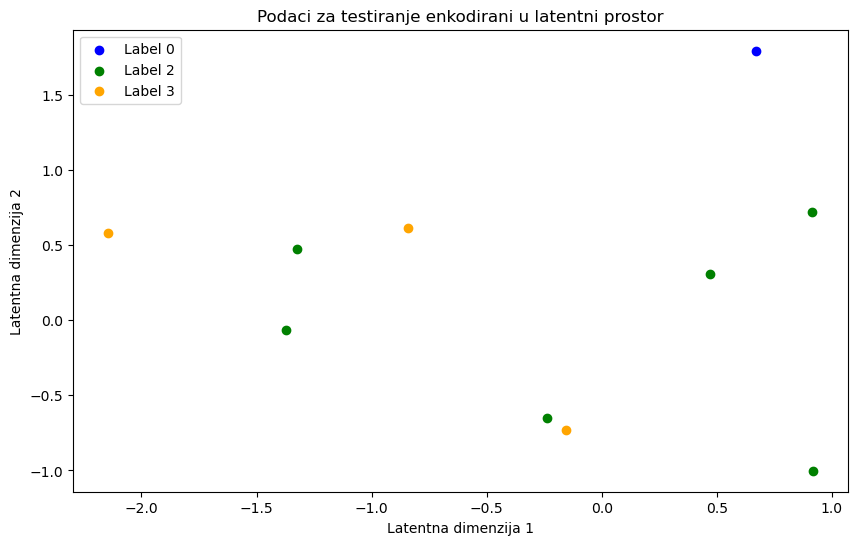

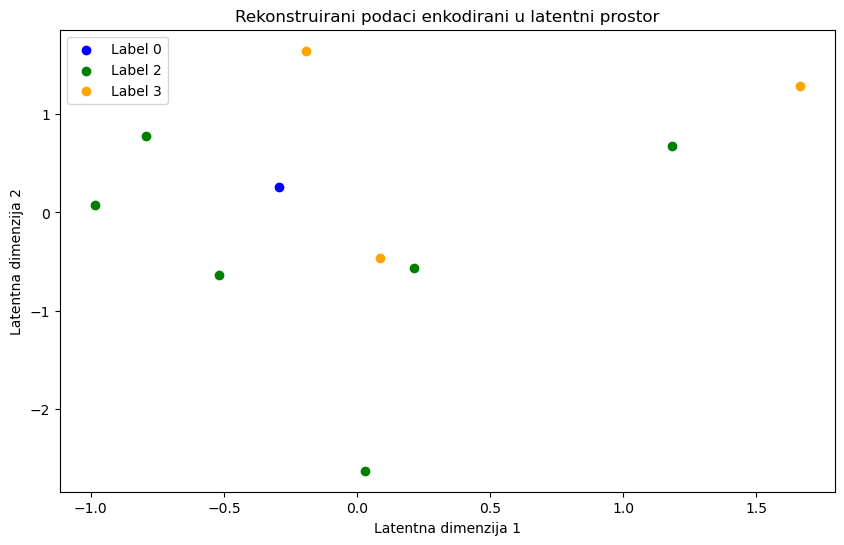

In [14]:

# Step 1: Randomly Select Peptides
num_peptides_to_visualize = 10  # Choose the number of peptides you want to visualize
selected_indices = np.random.choice(len(x_test), num_peptides_to_visualize, replace=False)

# Step 2: Get Subset of Data
selected_peptides = x_test[selected_indices]
selected_labels = y_test[selected_indices]

# Step 3: Perform Reconstruction
_, _, encoded_selected_peptides = vae.encoder.predict(selected_peptides)
reconstructed_peptides = vae.decoder.predict(encoded_selected_peptides)
_, _, encoded_reconstructed_peptides = vae.encoder.predict(reconstructed_peptides)

print(selected_peptides[2])
print(reconstructed_peptides[2])

# Step 4: Visualization
plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(encoded_selected_peptides, selected_labels)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirani podaci enkodirani u latentni prostor")
plot_reconstructed_data(encoded_reconstructed_peptides, selected_labels)
